In [1]:
!pip install -q kagglehub xgboost optuna

In [2]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("naiyakhalid/flood-prediction-dataset")

print("Path to dataset files:", path)

Path to dataset files: /home/ggbaguidi/.cache/kagglehub/datasets/naiyakhalid/flood-prediction-dataset/versions/1


In [3]:
# List files in dataset
!ls -l $path

total 2300
-rw-rw-r-- 1 ggbaguidi ggbaguidi 2354496 Mar  5 13:20 flood.csv


In [4]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

from xgboost import XGBRegressor

import optuna

In [5]:
df = pd.read_csv(path + "/flood.csv")
df

,MonsoonIntensity,TopographyDrainage,RiverManagement,Deforestation,Urbanization,ClimateChange,DamsQuality,Siltation,AgriculturalPractices,Encroachments,...,DrainageSystems,CoastalVulnerability,Landslides,Watersheds,DeterioratingInfrastructure,PopulationScore,WetlandLoss,InadequatePlanning,PoliticalFactors,FloodProbability
0,3,8,6,6,4,4,6,2,3,2,...,10,7,4,2,3,4,3,2,6,0.450
1,8,4,5,7,7,9,1,5,5,4,...,9,2,6,2,1,1,9,1,3,0.475
2,3,10,4,1,7,5,4,7,4,9,...,7,4,4,8,6,1,8,3,6,0.515
3,4,4,2,7,3,4,1,4,6,4,...,4,2,6,6,8,8,6,6,10,0.520
4,3,7,5,2,5,8,5,2,7,5,...,7,6,5,3,3,4,4,3,4,0.475
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49995,3,7,4,7,5,9,4,6,10,4,...,7,3,8,8,6,1,5,4,2,0.535
49996,3,10,3,8,3,3,4,4,3,11,...,8,6,3,6,4,4,2,4,5,0.510
49997,4,4,5,7,2,1,4,5,6,7,...,4,6,4,1,5,1,6,4,3,0.430
49998,4,5,4,4,6,3,10,2,6,11,...,6,3,4,7,6,2,4,0,11,0.515


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 21 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   MonsoonIntensity                 50000 non-null  int64  
 1   TopographyDrainage               50000 non-null  int64  
 2   RiverManagement                  50000 non-null  int64  
 3   Deforestation                    50000 non-null  int64  
 4   Urbanization                     50000 non-null  int64  
 5   ClimateChange                    50000 non-null  int64  
 6   DamsQuality                      50000 non-null  int64  
 7   Siltation                        50000 non-null  int64  
 8   AgriculturalPractices            50000 non-null  int64  
 9   Encroachments                    50000 non-null  int64  
 10  IneffectiveDisasterPreparedness  50000 non-null  int64  
 11  DrainageSystems                  50000 non-null  int64  
 12  CoastalVulnerabili

**1. Dataset Overview:**<br>
    - The dataset contains 50,000 entries with 21 columns in total.<br>
    - There are 20 feature columns and 1 target column (FloodProbability).<br><br>
**2. Data Types:**<br>
    - 20 columns are of type int64.<br>
    - The target variable, FloodProbability, is of type float64.<br><br>
**3. Data Quality:**<br>
    - There are no null values in any column.<br>
    - All features are numeric.<br><br>
**4. Potential Analysis Approaches:** <br>
    - Given continious nature of the data, regression techniques would be appropriate for predicting FloodProbability.<br>
    - Correlation analysis can identify relationships between features and the target.<br>
    - Feature importance analysis could reveal which factors have the strongest influence on flood probability.<br>

# Explanatory Data Analysis

### 1. Histogram Analysis

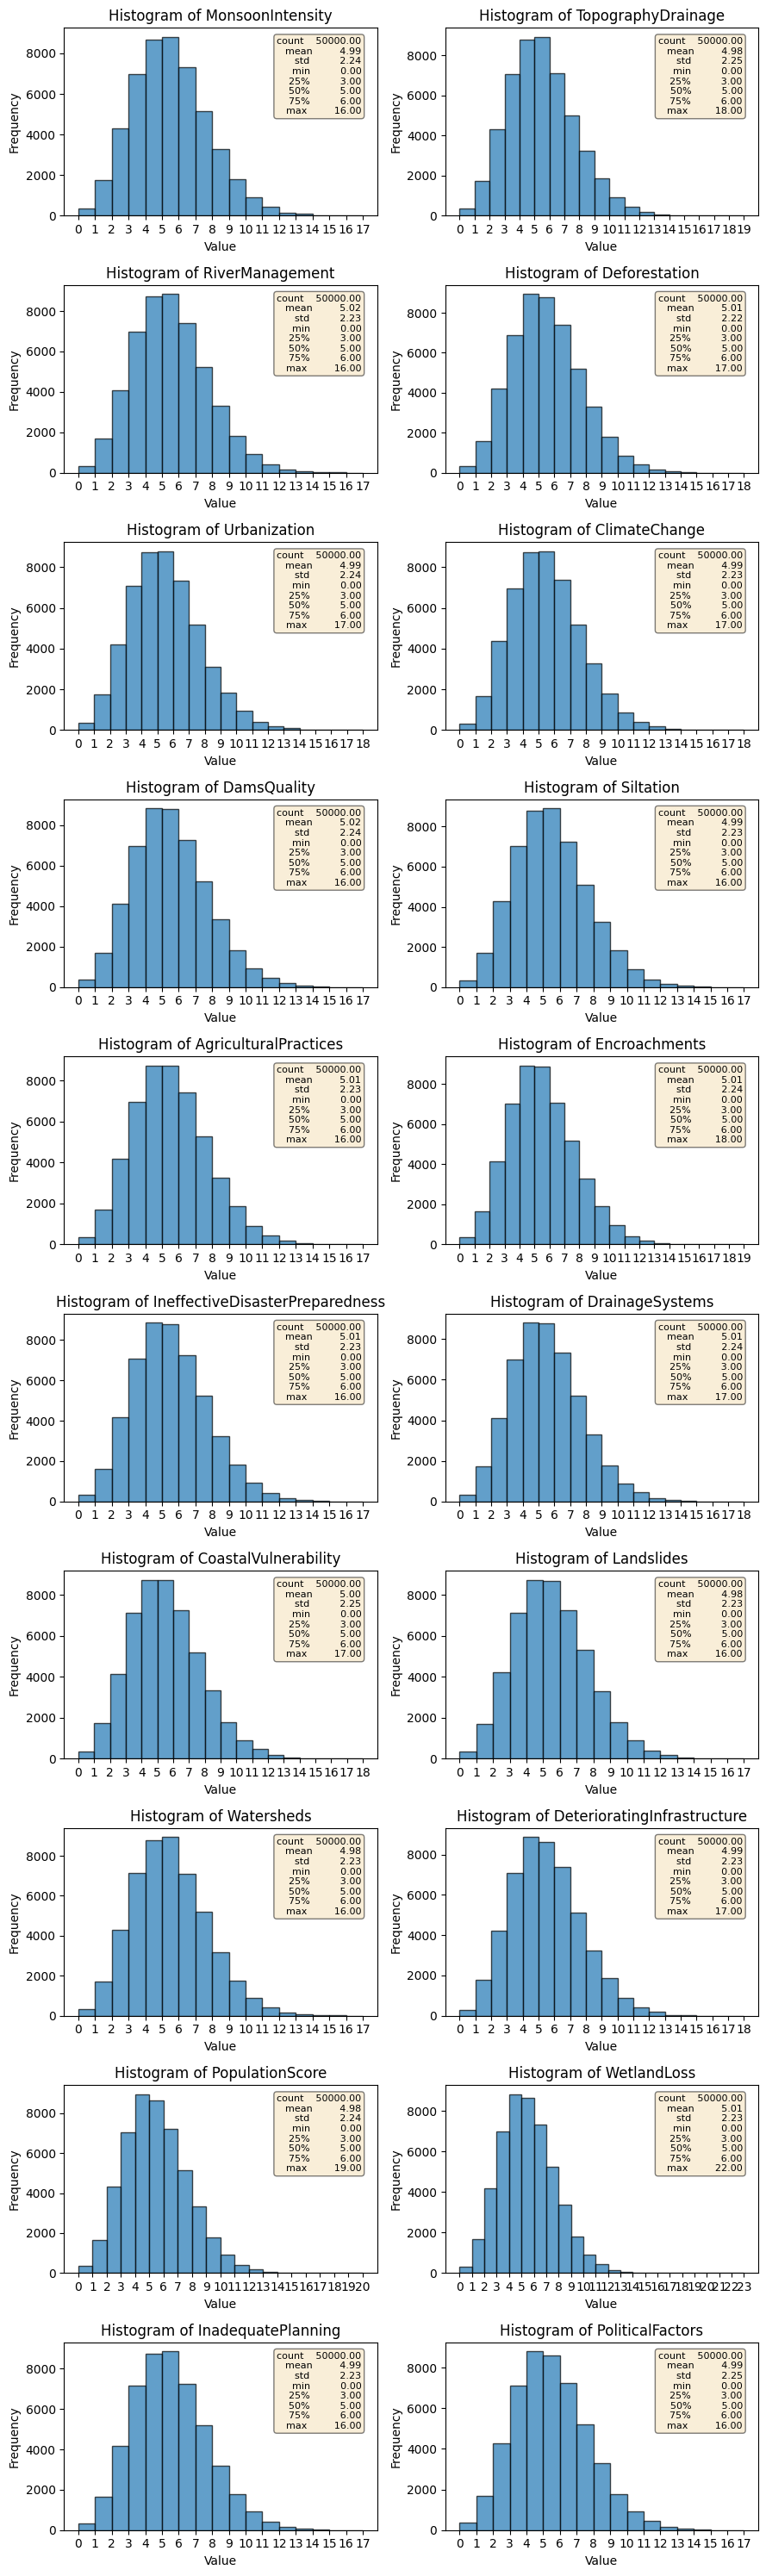

In [7]:
# Remove 'FloodProbability' column from the columns list
columns = df.drop('FloodProbability', axis=1).columns
n_cols = 2
n_rows = int(np.ceil(len(columns) / n_cols))

# Create subplots
fig, axes = plt.subplots(nrows=n_rows, ncols=2, figsize=(9, n_rows * 3))
axes = axes.flatten()

# Plot histograms for each column except 'FloodProbability'
for i, column in enumerate(columns):
    ax = axes[i]
    col_data = df[column]
    bins = np.arange(col_data.min(), col_data.max() + 2)
    ax.hist(col_data, bins=bins, alpha=0.7, edgecolor='k')
    ax.set_title(f'Histogram of {column}')
    ax.set_xlabel('Value')
    ax.set_ylabel('Frequency')
    ax.set_xticks(bins)
    
    # Summary statistics text
    summary_text = col_data.describe().apply(lambda x: f'{x:.2f}').to_string()
    ax.text(0.95, 0.95, summary_text, transform=ax.transAxes, fontsize=8,
            verticalalignment='top', horizontalalignment='right',
            bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

# Remove any unused subplots
for ax in axes[len(columns):]:
    fig.delaxes(ax)
    
plt.tight_layout()
plt.show()

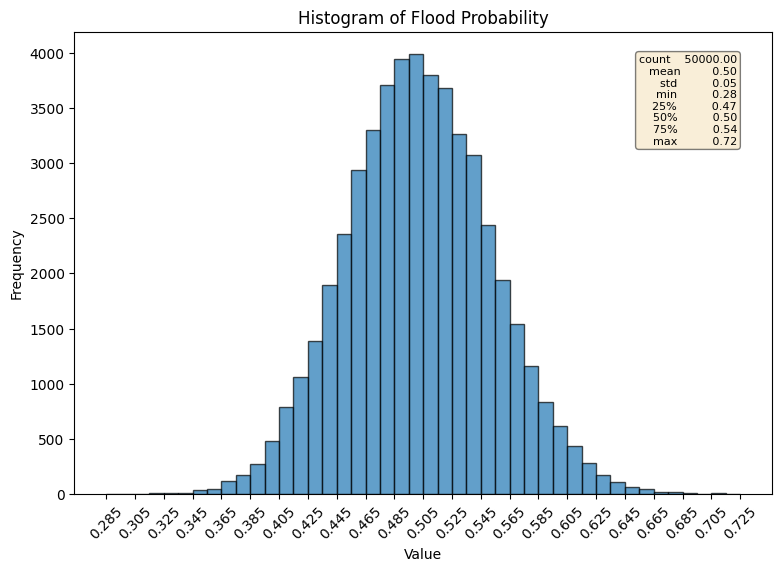

In [8]:
# Create subplots
fig, ax = plt.subplots(figsize=(9, 6))
bins = np.linspace(df['FloodProbability'].min(), df['FloodProbability'].max(), 45) # min, max, bar count

# Plot FloodProbability
ax.hist(df['FloodProbability'], bins=bins, alpha=0.7, edgecolor='k')
ax.set_title(f'Histogram of Flood Probability')
ax.set_xlabel('Value')
ax.set_ylabel('Frequency')
ax.set_xticks(bins[::2])
ax.tick_params(axis='x', rotation=45)
    
# Summary statistics text
summary_text = df['FloodProbability'].describe().apply(lambda x: f'{x:.2f}').to_string()
ax.text(0.95, 0.95, summary_text, transform=ax.transAxes, fontsize=8,
        verticalalignment='top', horizontalalignment='right',
        bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

plt.show()

### 2. Correlation Analysis

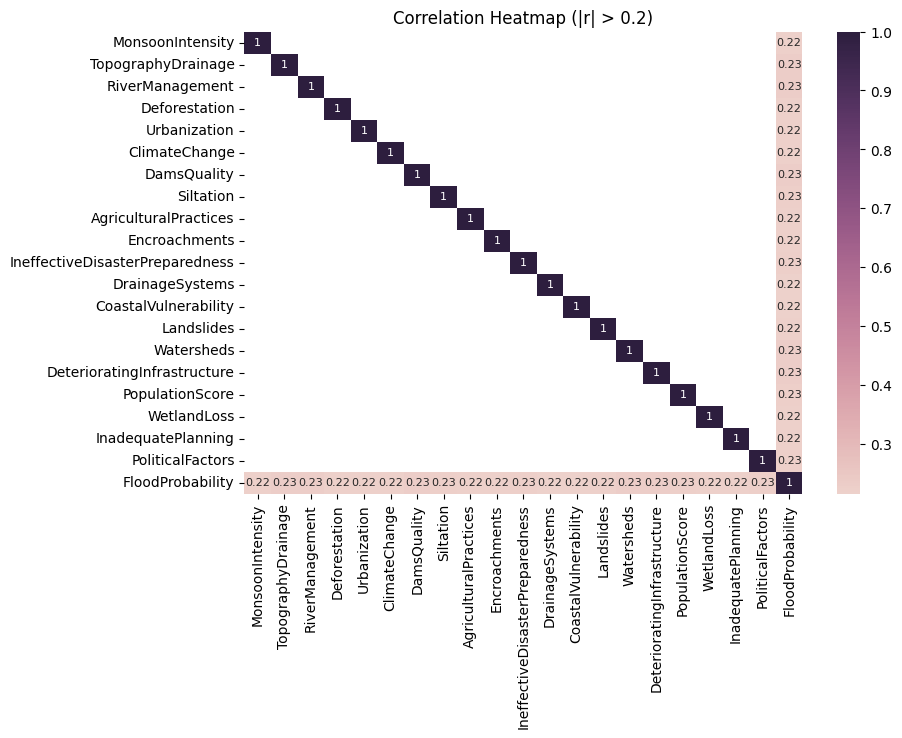

In [9]:
fig, ax = plt.subplots(figsize=(9, 6))

# Plot Heatmap
corr_matrix = df.corr()
mask = np.abs(corr_matrix) > 0.2
sns.heatmap(corr_matrix, annot=True, cmap=sns.cubehelix_palette(as_cmap=True), mask=~mask, annot_kws={"size": 8})

plt.title('Correlation Heatmap (|r| > 0.2)')
plt.show()

**Conclusions**
- All columns are roughly bell-shaped. This is acceptable, and the dataset doesn't strictly need transformation.
- The correlations between individual features and Flood Probability appear to be relatively consistent, with no single feature showing a substantially stronger relationship than the others.

# Preprocessing

In [10]:
def preprocess(df):
    df = df.copy()
    
    X = df.drop('FloodProbability', axis=1)
    y = df['FloodProbability']
    
    return X, y

In [11]:
X, y = preprocess(df)

# Pipeline

In [12]:
def build_model(params=None):
    numerical_transformer = Pipeline(steps=[
        ('MinMax Scaler', MinMaxScaler())
    ])
    
    preprocessor = ColumnTransformer(transformers=[
        ('Numerical Transformer', numerical_transformer, X.select_dtypes(np.number).columns)
    ], remainder='passthrough')
    
    if params is None:
        xgb_model = XGBRegressor(random_state=42)
    else:
        xgb_model = XGBRegressor(random_state=42, **params)
        
    model = Pipeline(steps=[
        ('Preprocess', preprocessor),
        ('XGBModel', xgb_model)
    ])
    
    return model

# Train

## Cross Validation

In [13]:
model = build_model()

cv_scores = cross_val_score(model, X, y, cv=5, scoring='neg_root_mean_squared_error')
cv_rmse = -cv_scores.mean()
print(f"Cross-validation RMSE: {cv_rmse}")

Cross-validation RMSE: 0.013377775099253853


## Train Test Split & HyperParameter Optimization

In [14]:
def print_metrics(target, predictions):
    rmse = np.sqrt(mean_squared_error(target, predictions))
    r2 = r2_score(target, predictions)
    mae = mean_absolute_error(target, predictions)
    print(f'Root Mean Squarred Error: {rmse}\nR-squared (r^2): {r2}\nMean Absolute Error: {mae}')

In [15]:
X, y = preprocess(df)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, shuffle=True, random_state=42)
model.fit(X_train, y_train)

Pipeline(steps=[('Preprocess',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('Numerical Transformer',
                                                  Pipeline(steps=[('MinMax '
                                                                   'Scaler',
                                                                   MinMaxScaler())]),
                                                  Index(['MonsoonIntensity', 'TopographyDrainage', 'RiverManagement',
       'Deforestation', 'Urbanization', 'ClimateChange', 'DamsQuality',
       'Siltation', 'AgriculturalPractices', 'Encroachments',
       'Ineffecti...
                              feature_types=None, gamma=None, grow_policy=None,
                              importance_type=None,
                              interaction_constraints=None, learning_rate=None,
                              max_bin=None, max_cat_threshold=None,
                              max_cat_to_onehot=None, max_delta_step=None,
                              max_depth=None, max_leaves=None,
                              min_child_weight=None, missing=nan,
                              monotone_constraints=None, multi_strategy=None,
                              n_estimators=None, n_jobs=None,
                              num_parallel_tree=None, random_state=42, ...))])

In [16]:
predictions = model.predict(X_test)
print_metrics(y_test, predictions)

Root Mean Squarred Error: 0.013584748491394204
R-squared (r^2): 0.9261235596294177
Mean Absolute Error: 0.010802139900875092


## HyperParameter Optimizing

In [17]:
X, y = preprocess(df)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, shuffle=True, random_state=42) 
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.17, shuffle=True, random_state=42)

Splitted data to Train, Validation and Test sets
- 75% Train Set
- 15% Validation Set
- 10% Test Set

In [18]:
def objective(trial):
    params = {
        'max_depth': trial.suggest_int('max_depth', 1, 20),
        'learning_rate': trial.suggest_float('learning_rate', 1e-3, 1.0, log=True),
        'n_estimators': trial.suggest_int('n_estimators', 100, 2000),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'gamma': trial.suggest_float('gamma', 1e-8, 1.0, log=True),
        'reg_alpha': trial.suggest_float('reg_alpha', 1e-8, 1.0, log=True),
        'reg_lambda': trial.suggest_float('reg_lambda', 1e-8, 1.0, log=True),
    }
    
    model = build_model(params)
    model.fit(X_train, y_train)
    
    preds = model.predict(X_val)
    rmse = np.sqrt(mean_squared_error(y_val, preds))
    return rmse

In [19]:
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=100)

[I 2025-03-05 13:30:06,658] A new study created in memory with name: no-name-039e7315-0c04-4033-8639-fd39d28307d7
[I 2025-03-05 13:30:14,143] Trial 0 finished with value: 0.018469777337049697 and parameters: {'max_depth': 14, 'learning_rate': 0.1984464162071847, 'n_estimators': 1858, 'min_child_weight': 7, 'subsample': 0.7455688840835843, 'colsample_bytree': 0.7270039536168158, 'gamma': 1.69048858576441e-08, 'reg_alpha': 9.722927907271044e-07, 'reg_lambda': 2.669645939027241e-07}. Best is trial 0 with value: 0.018469777337049697.
[I 2025-03-05 13:30:25,948] Trial 1 finished with value: 0.005870561895087168 and parameters: {'max_depth': 6, 'learning_rate': 0.05358650349843421, 'n_estimators': 1922, 'min_child_weight': 7, 'subsample': 0.5854158544234243, 'colsample_bytree': 0.6348712685177063, 'gamma': 8.061942322887948e-06, 'reg_alpha': 1.5940941124178e-07, 'reg_lambda': 8.836151153649732e-07}. Best is trial 1 with value: 0.005870561895087168.
[I 2025-03-05 13:30:31,720] Trial 2 finishe

In [20]:
best_params = study.best_params

In [21]:
model = build_model(best_params)
model.fit(X_train, y_train)
predictions = model.predict(X_test)
print_metrics(y_test, predictions)

Root Mean Squarred Error: 0.00024062741983028684
R-squared (r^2): 0.9999766295665925
Mean Absolute Error: 0.00015814719295501728


In [23]:
MODEL_PATH = './../checkpoints/xgboost_model.pkl'
# Import Pickle
import pickle

# Save the model to a file
with open(MODEL_PATH, 'wb') as file:
    pickle.dump(model, file)

In [24]:
# Load the model using Pickle
with open(MODEL_PATH, 'rb') as file:
    loaded_model_pickle = pickle.load(file)

In [25]:
predictions = loaded_model_pickle.predict(X_test)
print_metrics(y_test, predictions)

Root Mean Squarred Error: 0.00024062741983028684
R-squared (r^2): 0.9999766295665925
Mean Absolute Error: 0.00015814719295501728
